# Import Libraries/Packages

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 

from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential  
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
import keras.backend as K

from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD, Adam

from keras_tuner import HyperModel
from keras_tuner.tuners import GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Load Dataset

In [2]:
data_train_temp = np.load('kmnist-train-imgs.npz')
labels_train_temp = np.load('kmnist-train-labels.npz')
data_test_temp = np.load('kmnist-test-imgs.npz')
labels_test_temp = np.load('kmnist-test-labels.npz')

In [3]:
data_train = data_train_temp['arr_0']
labels_train = labels_train_temp['arr_0']
data_test = data_test_temp['arr_0']
labels_test = labels_test_temp['arr_0']

In [4]:
oh_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oh_encoder.fit(labels_train.reshape(-1,1))
labels_train_hot = oh_encoder.transform(labels_train.reshape(-1,1))
labels_test_hot = oh_encoder.transform(labels_test.reshape(-1,1))

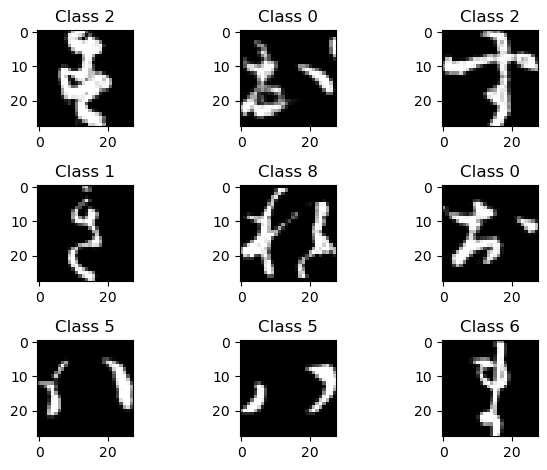

In [5]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(data_train))
    plt.imshow(data_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(labels_train[num]))
    
plt.tight_layout()

In [6]:
data_train = data_train.reshape(60000, 784) 
data_test = data_test.reshape(10000, 784)   

data_train = data_train.astype('float32')   
data_test = data_test.astype('float32')

data_train /= 255                        
data_test /= 255

#data_train = data_train.reshape((data_train.shape[0], 28, 28, 1))
#data_test = data_test.reshape((data_test.shape[0], 28, 28, 1))

print("Training matrix shape", data_train.shape)
print("Testing matrix shape", data_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


# Part 1

## Section A: Design SAE Network

In [7]:
def build_enc(neck_width):
    enc_model = Sequential()
    enc_model.add(Dense(784,))
    enc_model.add(Dense(800, activation='relu'))
    enc_model.add(Dense(200, activation='relu'))
    enc_model.add(Dense(neck_width, activation='relu'))
    return enc_model

In [8]:
def build_dec(neck_width):
    dec_model = Sequential()
    dec_model.add(Dense(neck_width,))
    dec_model.add(Dense(200, activation='relu'))
    dec_model.add(Dense(800, activation='relu'))
    dec_model.add(Dense(784,))
    return dec_model

In [9]:
def build_sae(hp):
    neck_width = hp.Int('bottle_neck', min_value=50, max_value=100, step=5)
    
    enc_model = build_enc(neck_width)
    dec_model = build_dec(neck_width)
    
    sae_model = Sequential()
    sae_model.add(enc_model)
    sae_model.add(dec_model)
    
    return sae_model

## Section B: Train the SAE Models

### 1) Correntropy Loss Function

In [10]:
def correntropy_loss(sigma):
    def loss(y_true, y_pred):
        kernel = K.exp(-K.square(y_pred - y_true) / (2 * sigma * sigma))
        return -K.mean(kernel)
    return loss

### 2) Create Hypermodels

In [11]:
class SAEHyperModel(HyperModel):
    def build(self, hp):
        model = build_sae(hp)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp_sae.Choice('batch_size', [32, 64, 128, 256]);
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs
        )

In [12]:
class SAECEHyperModel(HyperModel):
    def build(self, hp):
        sigma = hp.Choice('sigma', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
        
        model = build_sae(hp)
        model.compile(optimizer='adam', loss=correntropy_loss(sigma))
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp_sae.Choice('batch_size', [32, 64, 128, 256]);
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs
        )

### 3) Create Hyperparameters and Tuners

In [13]:
hp_sae = HyperParameters()

hp_sae.Int('bottle_neck', min_value=50, max_value=100, step=5);
hp_sae.Choice('batch_size', [32, 64, 128, 256]);

In [14]:
hp_sae_ce = HyperParameters()

hp_sae_ce.Int('bottle_neck', min_value=50, max_value=100, step=5);
hp_sae_ce.Choice('batch_size', [32, 64, 128, 256]);
hp_sae_ce.Choice('sigma', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

In [15]:
sae_tuner = GridSearch(
    SAEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae,
    max_retries_per_trial=20,
    directory='sae_tuner',
    project_name='sae_tuning'
)

Reloading Tuner from sae_tuner\sae_tuning\tuner0.json


In [16]:
sae_ce_tuner = GridSearch(
    SAECEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae_ce,
    max_retries_per_trial=20,
    directory='sae_ce_tuner',
    project_name='sae_ce_tuning'
)

Reloading Tuner from sae_ce_tuner\sae_ce_tuning\tuner0.json


### 4) Search for Optimal Encoder [MSE, No Noise]

In [17]:
callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.005)

In [18]:
sae_tuner.search(data_train, data_train, epochs=20, validation_split=0.3, callbacks=[callback])

In [19]:
best_sae = sae_tuner.get_best_models(num_models=1)[0]

In [20]:
best_sae.fit(data_train, data_train)

1875/1875 [==============================] - 36s 19ms/step - loss: 0.0402


In [21]:
best_encoder = best_sae.layers[0]

In [22]:
bottle_neck_layer = best_encoder.layers[-1]
neck_width = bottle_neck_layer.units

In [23]:
encoded_train_data = best_encoder.predict(data_train)
encoded_test_data = best_encoder.predict(data_test)

313/313 [==============================] - 1s 3ms/step


### 5) Search for Optimal Encoder [CE, No Noise]

In [24]:
sae_ce_tuner.search(data_train, data_train, epochs=20, validation_split=0.3, callbacks=[callback])

In [25]:
best_sae_ce = sae_ce_tuner.get_best_models(num_models=1)[0]

In [26]:
best_sae_ce.fit(data_train, data_train)

1875/1875 [==============================] - 38s 19ms/step - loss: -0.9624


In [27]:
best_encoder_ce = best_sae_ce.layers[0]

In [28]:
bottle_neck_layer_ce = best_encoder_ce.layers[-1]
neck_width_ce = bottle_neck_layer_ce.units

In [29]:
encoded_train_data_ce = best_encoder_ce.predict(data_train)
encoded_test_data_ce = best_encoder_ce.predict(data_test)

313/313 [==============================] - 1s 3ms/step


## Section C: Design SAE+Classifier

In [30]:
def build_mlp(hp):
    cw = hp_clf.Int('clf_width', min_value=5, max_value=20, step=5)
    ch = hp_clf.Int('clf_height', min_value=1, max_value=3, step=1)
    neck_w = hp_clf.Choice('neck_width', [neck_width])
    
    mlp_model = Sequential()
    mlp_model.add(Dense(neck_w,))
    for i in range(ch):
        mlp_model.add(Dense(cw, activation='relu'))
    mlp_model.add(Dense(10, activation='softmax'))
    
    return mlp_model

## Section D: Train SAE+Classifier

### 1) Create Hypermodels

In [31]:
class CLFHyperModel(HyperModel):
    def build(self, hp):
        model = build_mlp(hp)
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp_clf.Choice('batch_size', [32, 64, 128, 256]);
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs
        )

In [32]:
#class CLFCEHyperModel(HyperModel):
#    def build(self, hp):
#        model = build_mlp(hp)
#        model.compile(optimizer='adam', loss='categorical_crossentropy')
#        return model
#    
#    def fit(self, hp, model, *args, **kwargs):
#        batch_size = hp_sae.Choice('batch_size', [32, 64, 128, 256]);
#        return model.fit(
#            *args,
#           batch_size=batch_size,
#            **kwargs
#        )

### 2) Create Hyperparameters and Tuners

In [33]:
hp_clf = HyperParameters()

hp_clf.Int('clf_width', min_value=5, max_value=20, step=5);
hp_clf.Int('clf_height', min_value=1, max_value=3, step=1);
hp_clf.Choice('batch_size', [32,64,128,256]);
hp_clf.Choice('neck_width', [neck_width]);

In [34]:
#hp_clf_ce = HyperParameters()


#hp_clf_ce.Int('clf_width', min_value=5, max_value=20, step=5);
#hp_clf_ce.Int('clf_height', min_value=1, max_value=3, step=1);
#hp_clf_ce.Choice('batch_size', [32,64,128,256]);
#hp_clf_ce.Choice('neck_width', [neck_width]);
#hp_clf_ce.Choice('sigma', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]);

In [35]:
clf_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='clf_tuner',
    project_name='clf_tuning'
)

Reloading Tuner from clf_tuner\clf_tuning\tuner0.json


In [36]:
clf_ce_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='clf_ce_tuner',
    project_name='clf_ce_tuning'
)

Reloading Tuner from clf_ce_tuner\clf_ce_tuning\tuner0.json


### 3) Search for Optimal Classifier [MSE Encoder, No Noise]

In [38]:
clf_tuner.search(encoded_train_data, labels_train_hot, epochs=20, validation_split=0.3, callbacks=[callback])

In [39]:
best_clf = clf_tuner.get_best_models()[0]

In [40]:
best_clf.fit(encoded_train_data, labels_train_hot)

1875/1875 [==============================] - 2s 819us/step - loss: 1.1170


### 4) Search for Optimal Classifier [CE Encoder, No Noise]

In [41]:
clf_ce_tuner.search(encoded_train_data_ce, labels_train_hot, epochs=20, validation_split=0.3, callbacks=[callback])

In [42]:
best_clf_ce = clf_ce_tuner.get_best_models()[0]

In [43]:
best_clf_ce.fit(encoded_train_data_ce, labels_train_hot)

1875/1875 [==============================] - 2s 814us/step - loss: 1.1832


## Section E: Inject Noise

### 1) Create Noise Function and Add Noise

In [44]:
def add_noise(X, noise_level=0.10):
    """
    Add salt and pepper noise to a NumPy array.

    Parameters:
    - X: NumPy array (image or any numerical array)
    - noise_level: Proportion of elements to be altered. Default is 0.05 (5%)
    
    Returns:
    - Noisy array
    """

    # Copy the input array to avoid overwriting the original data
    X_noisy = np.copy(X)

    # Calculate the number of elements to be affected by noise
    num_noise = int(noise_level * X.size)

    # Choose random locations to place the salt and pepper noise
    coords = [np.random.randint(0, i - 1, num_noise) for i in X.shape]

    # Add salt noise (maximum value)
    X_noisy[tuple(coords)] = np.max(X)

    # Choose random locations for pepper noise
    coords = [np.random.randint(0, i - 1, num_noise) for i in X.shape]

    # Add pepper noise (minimum value)
    X_noisy[tuple(coords)] = np.min(X)

    return X_noisy

# Example usage
# Assuming 'array' is your numpy array:
# noisy_array = add_salt_and_pepper_noise(array, noise_level=0.05)

In [48]:
noisy_train_data = add_noise(data_train, 0.10)
noisy_test_data = add_noise(data_test, 0.10)

noisy_train_data = noisy_train_data.reshape(noisy_train_data.shape[0], 784)
noisy_test_data = noisy_test_data.reshape(noisy_test_data.shape[0], 784)

data_train = data_train.reshape(data_train.shape[0], 784)
data_test = data_test.reshape(data_test.shape[0], 784)

noisy_train_data = noisy_train_data.astype('float32')
noisy_test_data = noisy_test_data.astype('float32')

### 2) Create New Tuners

In [49]:
noisy_sae_tuner = GridSearch(
    SAEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae,
    max_retries_per_trial=20,
    directory='noisy_sae_tuner',
    project_name='noisy_sae_ce_tuning'
)

Reloading Tuner from noisy_sae_tuner\noisy_sae_ce_tuning\tuner0.json


In [61]:
noisy_sae_ce_tuner = GridSearch(
    SAECEHyperModel(),
    objective='loss',
    hyperparameters=hp_sae_ce,
    max_retries_per_trial=20,
    directory='noisy_sae_ce_tuner',
    project_name='noisy_sae_ce_tuning'
)

In [51]:
noisy_clf_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='noisy_clf_tuner',
    project_name='noisy_clf_tuning'
)

In [52]:
noisy_clf_ce_tuner = GridSearch(
    CLFHyperModel(),
    objective='loss',
    hyperparameters=hp_clf,
    directory='noisy_clf_ce_tuner',
    project_name='noisy_clf_ce_tuning'
)

### 3) Search for Optimal Encoder [MSE, Noise]

In [53]:
noisy_sae_tuner.search(noisy_train_data, data_train, epochs=1, validation_split=0.3, callbacks=[callback])

In [54]:
best_noisy_sae = noisy_sae_tuner.get_best_models()[0]

In [55]:
best_noisy_sae.fit(noisy_train_data, data_train)

1875/1875 [==============================] - 34s 18ms/step - loss: 0.0578


In [56]:
best_noisy_encoder = best_noisy_sae.layers[0]

In [57]:
noisy_bottle_neck_layer = best_noisy_encoder.layers[-1]
noisy_neck_width = noisy_bottle_neck_layer.units

In [58]:
noisy_encoded_train_data = best_noisy_encoder.predict(data_train)
noisy_encoded_test_data = best_noisy_encoder.predict(data_test)

313/313 [==============================] - 1s 3ms/step


### 4) Search for Optimal Encoder [CE, Noise]

In [62]:
noisy_sae_ce_tuner.search(noisy_train_data, data_train, epochs=1, validation_split=0.3, callbacks=[callback])

Trial 28 Complete [00h 00m 33s]
loss: -0.9580605626106262

Best loss So Far: -0.9729934930801392
Total elapsed time: 00h 14m 15s

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
50                |50                |bottle_neck
128               |64                |batch_size
0.9               |1                 |sigma

 731/1313 [===============>..............] - ETA: 12s - loss: -0.9629

KeyboardInterrupt: 

In [64]:
best_noisy_sae_ce = noisy_sae_ce_tuner.get_best_models()[0]

In [65]:
best_noisy_sae_ce.fit(noisy_train_data, data_train)

1875/1875 [==============================] - 38s 20ms/step - loss: -0.9787


In [ ]:
best_noisy_encoder_ce = best_noisy_sae_ce.layers[0]

In [ ]:
noisy_bottle_neck_layer_ce = best_noisy_encoder_ce.layers[-1]
noisy_neck_width_ce = noisy_bottle_neck_layer_ce.units

In [ ]:
noisy_encoded_train_data_ce = best_noisy_encoder_ce.predict(data_train)
noisy_encoded_test_data_ce = best_noisy_encoder_ce.predict(data_test)

### 5) Search for Optimal Classifier [MSE Encoder, Noise]

In [ ]:
noisy_clf_tuner.search(noisy_encoded_train_data, labels_train_hot, epochs=1, validation_split=0.3, callbacks=[callback])

In [ ]:
best_noisy_clf = noisy_clf_tuner.get_best_models(num_models==1)[0]

In [ ]:
best_noisy_clf.fit(noisy_encoded_train_data, labels_train)

### 6) Search for Optimal Classifier [CE Encoder, Noise]

In [ ]:
noisy_clf_ce_tuner.search(noisy_encoded_train_data_ce, labels_train, epochs=1, validation_split=0.3, callbacks=[callback])

In [ ]:
best_noisy_clf_ce = noisy_clf_ce_tuner.get_best_models(num_models==1)[0]

In [ ]:
best_noisy_clf_ce.fit(noisy_encoded_train_data_ce, labels_train)

## Section F: Results

### 1) SAE+Classifier [MSE Encoder, No Noise]

In [ ]:
mse_predictions = best_clf.predict(data_test)

In [ ]:
cm_mse = confusion_matrix(labels_test, mse_predictions)

disp_mse = ConfusionMatrixDisplay(confusion_matrix=cm_mse)
disp_mse.plot()
plt.show()

### 2) SAE+Classifier [CE Encoder, No Noise]

In [ ]:
ce_predictions = best_clf_ce.predict(data_test)

In [ ]:
cm_ce = confusion_matrix(labels_test, ce_predictions)

disp_ce = ConfusionMatrixDisplay(confusion_matrix=cm_ce)
disp_ce.plot()
plt.show()

### 3) SAE+Classifier [MSE Encoder, Noise]

In [ ]:
noisy_mse_predictions = best_noisy_clf.predict(data_test)

In [ ]:
cm_noisy = confusion_matrix(labels_test, noisy_mse_predictions)

disp_noisy_mse = ConfusionMatrixDisplay(confusion_matrix=cm_noisy)
disp_noisy_mse.plot()
plt.show()

### 4) SAE+Classifier [CE Encoder, Noise]

In [ ]:
noisy_ce_predictions = best_noisy_clf_ce.predict(data_test)

In [ ]:
cm_noisy_ce = confusion_matrix(labels_test, noisy_mse_predictions)

disp_noisy_mse = ConfusionMatrixDisplay(confusion_matrix=cm_noisy)
disp_noisy_mse.plot()
plt.show()